<a href="https://colab.research.google.com/github/f1shstyxx/DS_capstone/blob/main/Project_3_LLM/Project_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 3 - Supervised Learning for Text Summarization

## Business Understanding

### Background

### Dataset Details

### Project Goals

### Project Considerations

## Data Understanding

In [29]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, \
  accuracy_score, ConfusionMatrixDisplay
from transformers import BertTokenizer, EncoderDecoderModel, TrainingArguments,\
  Trainer, DataCollatorForSeq2Seq
import transformers
from transformers import EarlyStoppingCallback
import mlflow
import mlflow.transformers

# set random seed for reproducibility
def set_seed(seed_value=42):
  random.seed(seed_value)
  np.random.seed(seed_value)
  os.environ['PYTHONHASHSEED'] = str(seed_value)

set_seed()

In [2]:
# install hugging face
# !pip install datasets

In [5]:
# load samsum dataset
from datasets import load_dataset

start_time = time.time()

dataset = load_dataset('knkarthick/samsum')

end_time = time.time()
print(f"Dataset loaded in {(end_time - start_time)/60:.2f} minutes")

Dataset loaded in 0.02 minutes


In [6]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14732
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
})


In [7]:
print(dataset['train'][0])

{'id': '13818513', 'dialogue': "Amanda: I baked  cookies. Do you want some?\nJerry: Sure!\nAmanda: I'll bring you tomorrow :-)", 'summary': 'Amanda baked cookies and will bring Jerry some tomorrow.'}


In [8]:
# convert train, validation and test datasets to dataframes for EDA
# pandas dfs are better for quick exploration than Hugging Face datasets
# hugging face dataset objects are good for modeling, but less flexible for:
# describe(), filtering, plotting, sample inspection

df_train = pd.DataFrame(dataset['train'])
print(df_train.head())

df_val = pd.DataFrame(dataset['validation'])
print(df_val.head())

df_test = pd.DataFrame(dataset['test'])
print(df_test.head())

         id                                           dialogue  \
0  13818513  Amanda: I baked  cookies. Do you want some?\nJ...   
1  13728867  Olivia: Who are you voting for in this electio...   
2  13681000  Tim: Hi, what's up?\nKim: Bad mood tbh, I was ...   
3  13730747  Edward: Rachel, I think I'm in ove with Bella....   
4  13728094  Sam: hey  overheard rick say something\nSam: i...   

                                             summary  
0  Amanda baked cookies and will bring Jerry some...  
1  Olivia and Olivier are voting for liberals in ...  
2  Kim may try the pomodoro technique recommended...  
3  Edward thinks he is in love with Bella. Rachel...  
4  Sam is confused, because he overheard Rick com...  
         id                                           dialogue  \
0  13817023  A: Hi Tom, are you busy tomorrow’s afternoon?\...   
1  13716628  Emma: I’ve just fallen in love with this adven...   
2  13829420  Jackie: Madison is pregnant\nJackie: but she d...   
3  138196

### Text Exploration
Analyze the characteristics of the dialogues and summaries

In [9]:
# train df basic info and describe
print(df_train.info())
print(df_train.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14732 entries, 0 to 14731
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        14732 non-null  object
 1   dialogue  14731 non-null  object
 2   summary   14732 non-null  object
dtypes: object(3)
memory usage: 345.4+ KB
None
              id                                           dialogue  \
count      14732                                              14731   
unique     14732                                              14255   
top     13818513  Jimmy: Hey, guess what? My car's completely ka...   
freq           1                                                  4   

                                                  summary  
count                                               14732  
unique                                              14730  
top     Seth's pet Oreo that he got when he was 10 is ...  
freq                                                    2  

In [10]:
# length of train df
print(f"Length of train df: {len(df_train)}")

Length of train df: 14732


In [11]:
# text length analysis
# analysis will include speaker names
df_train['dialogue_length'] = df_train['dialogue'].apply(lambda x: len(str(x).split()))
print(f"\nAverage dialogue length: {df_train['dialogue_length'].mean():.2f} words")
print(f"\nMedian dialogue length: {df_train['dialogue_length'].median():.2f} words")
print(f"\nMinimum dialogue length: {df_train['dialogue_length'].min()} words")
print(f"\nMaximum dialogue length: {df_train['dialogue_length'].max()} words")


Average dialogue length: 93.79 words

Median dialogue length: 73.00 words

Minimum dialogue length: 1 words

Maximum dialogue length: 803 words


In [12]:
df_train['summary_length'] = df_train['summary'].apply(lambda x: len(str(x).split()))
print(f"\nAverage summary length: {df_train['summary_length'].mean():.2f} words")
print(f"\nMedian summary length: {df_train['summary_length'].median():.2f} words")
print(f"\nMinimum summary length: {df_train['summary_length'].min()} words")
print(f"\nMaximum summary length: {df_train['summary_length'].max()} words")


Average summary length: 20.32 words

Median summary length: 18.00 words

Minimum summary length: 1 words

Maximum summary length: 64 words


In [13]:
# check for missing values
print(df_train.isnull().sum())
print(df_val.isnull().sum())
print(df_test.isnull().sum())

id                 0
dialogue           1
summary            0
dialogue_length    0
summary_length     0
dtype: int64
id          0
dialogue    0
summary     0
dtype: int64
id          0
dialogue    0
summary     0
dtype: int64


In [14]:
# drop row from df_train with missing value in dialogue column
df_train = df_train.dropna(subset=['dialogue'])
print(df_train.isnull().sum())
print(f"\nLength of train df: {len(df_train)}")

id                 0
dialogue           0
summary            0
dialogue_length    0
summary_length     0
dtype: int64

Length of train df: 14731


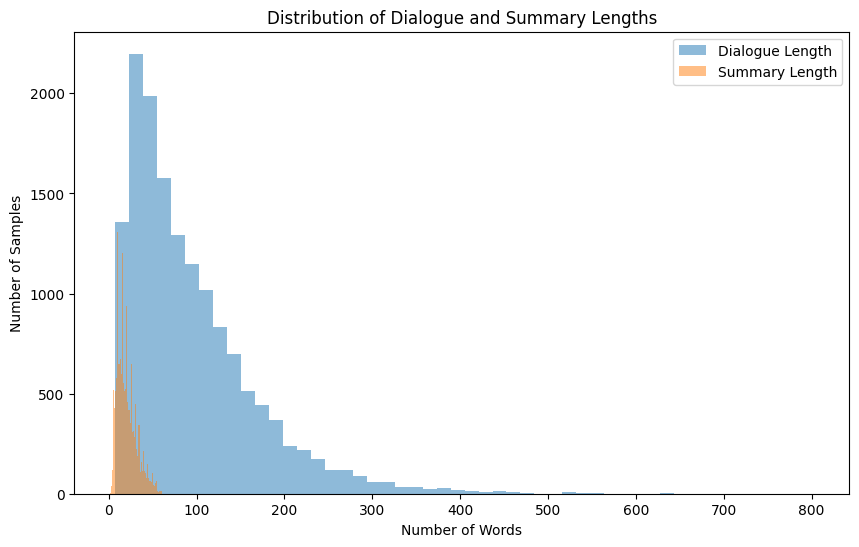

In [15]:
# plot dialogue vs summary lengths
plt.figure(figsize=(10, 6))
plt.hist(df_train['dialogue_length'], bins=50, alpha=0.5, label='Dialogue Length')
plt.hist(df_train['summary_length'], bins=50, alpha=0.5, label='Summary Length')
plt.xlabel('Number of Words')
plt.ylabel('Number of Samples')
plt.title('Distribution of Dialogue and Summary Lengths')
plt.legend()
plt.show()

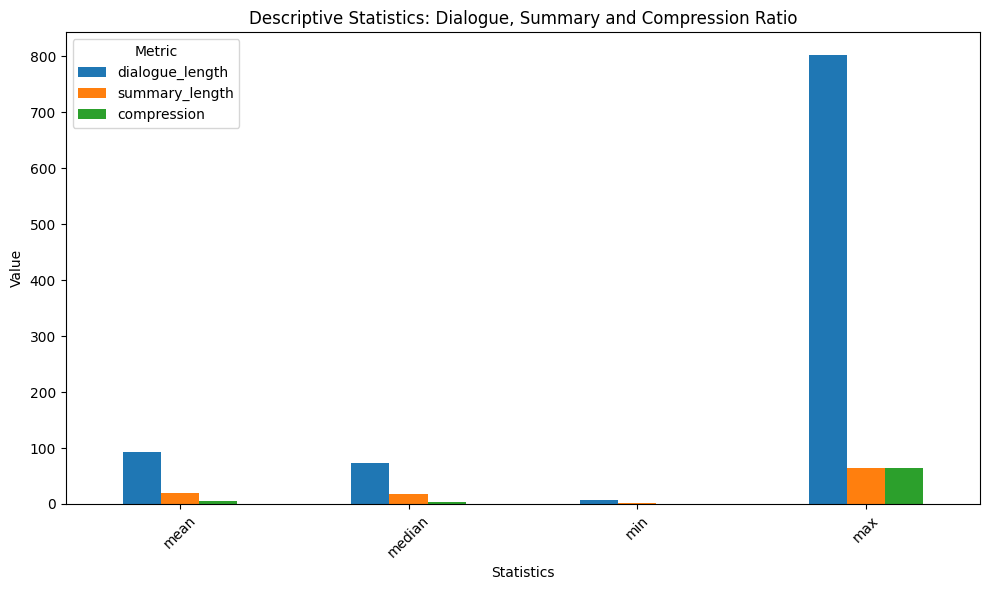

In [16]:
# plot dialogue, summary, and compression statistics
df_train['compression'] = df_train['dialogue_length'] / df_train['summary_length']
stats = df_train[['dialogue_length', 'summary_length', 'compression']].agg(['mean', 'median', 'min', 'max']).round(2).T

# plot statistics
stats.T.plot(kind='bar', figsize=(10,6))
plt.title('Descriptive Statistics: Dialogue, Summary and Compression Ratio')
plt.xlabel('Statistics')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

In [17]:
# examples of dialogue and summary
print(f"\nDialogue: {df_train['dialogue'][5]}")
print(f"\nSummary: {df_train['summary'][5]}")

print(f"\nDialogue: {df_train['dialogue'][1000]}")
print(f"\nSummary: {df_train['summary'][1000]}")


Dialogue: Neville: Hi there, does anyone remember what date I got married on?
Don: Are you serious?
Neville: Dead serious. We're on vacation, and Tina's mad at me about something. I have a strange suspicion that this might have something to do with our wedding anniversary, but I have nowhere to check.
Wyatt: Hang on, I'll ask my wife.
Don: Haha, someone's in a lot of trouble :D
Wyatt: September 17. I hope you remember the year ;)

Summary: Wyatt reminds Neville his wedding anniversary is on the 17th of September. Neville's wife is upset and it might be because Neville forgot about their anniversary.

Dialogue: Ann: Do you have plans for the holidays this year?
Mary: Well we thought of going for a hike somewhere beautiful
Mary: and you?
Ann: We talked about it last night and we thought maybe you would like to do sth together?
Mary: Why not
Mary: just remember that we're outdoorsy people :D
Ann: I know, but you're not even considering a nice beach somewhere?
Mary: weeeeell, that's not r

## Data Preparation

Prep data for input to BERT model
* implement appropriate tokenization
* create training and validation splits
* build data loaders for efficient model training

In [18]:
# initialize tokenizer
# converts input dialogue into token IDs for the encoder
# converts target summary into token IDs for the decoder
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

MAX_INPUT_LENGTH = 512
MAX_TARGET_LENGTH = 64

# define tokenize function
def tokenize_function(batch):

  # tokenize input dialogue
  inputs = tokenizer(
      batch['dialogue'],
      padding='max_length',
      truncation=True,
      max_length = MAX_INPUT_LENGTH,
  )

  # tokenize target summary
  with tokenizer.as_target_tokenizer():
    labels = tokenizer(
        batch['summary'],
        padding='max_length',
        truncation=True,
        max_length=MAX_TARGET_LENGTH,
  )

  # attach labels to inputs
  inputs['labels'] = labels['input_ids']
  return inputs

In [19]:
# tokenize train, validation, and test datasets

start_time = time.time()

# Remove examples with None in 'dialogue' or 'summary'
dataset['train'] = dataset['train'].filter(lambda x: x['dialogue'] is not None and x['summary'] is not None)

tokenized_train = dataset['train'].map(tokenize_function, batched=True)
tokenized_val = dataset['validation'].map(tokenize_function, batched=True)
tokenized_test = dataset['test'].map(tokenize_function, batched=True)

end_time = time.time()
print(f"Tokenization time: {(end_time - start_time)/60:.2f} minutes")

# Tokenization time: 50 sec on 7/25/25

Tokenization time: 0.01 minutes


In [20]:
# load a BERT2BERT pre-trained model (encoder-decoder)
# use patrickvonplaten/bert2bert-cnn_dailymail-fp16 as a BERT2BERT model fine-tuned on CNN/DailyMail
# encoder and decoder both use bert-case-uncased
# bert-case-uncased is a commonly used pretrained BERT model from the original BERT paper

model = EncoderDecoderModel.from_pretrained('patrickvonplaten/bert2bert-cnn_dailymail-fp16')

Some weights of the model checkpoint at patrickvonplaten/bert2bert-cnn_dailymail-fp16 were not used when initializing EncoderDecoderModel: ['decoder.bert.pooler.dense.bias', 'decoder.bert.pooler.dense.weight']
- This IS expected if you are initializing EncoderDecoderModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EncoderDecoderModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [21]:
# configure the model for the summarization task
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.eos_token_id = tokenizer.sep_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.vocab_size = model.config.encoder.vocab_size

## Modeling

In [36]:
# set up training arguments

training_args = TrainingArguments(
    output_dir="./bert2bert_samsum",
    save_steps=500,
    save_total_limit=2,  # keep only the last 2 saved models
    logging_steps=500,
    do_train=True,
    do_eval=True,
    do_predict=True,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=5,
    fp16=True,  # use mixed precision training
    metric_for_best_model="eval_loss",  # or "rougeL" if you're using ROUGE
    greater_is_better=False,
    report_to="tensorboard",  # enables TensorBoard
    learning_rate=5e-5,
    lr_scheduler_type="linear",  # or cosine, polynomial, constant
    warmup_steps=500,
)

# 2. Data collator
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

# 3. Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

C:\Users\jtlee\AppData\Local\Temp\ipykernel_15912\1344069364.py:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
start_time = time.time()

mlflow.set_experiment("BERT2BERT SAMSum")

with mlflow.start_run():
    mlflow.log_param("model", "bert2bert-cnn_dailymail-fp16")
    mlflow.log_param("epochs", 3)
    mlflow.log_param("batch_size", 4)
    
    # Start training
    trainer.train()

    # Log final model and tokenizer
    model.save_pretrained("./bert2bert_samsum_final")
    tokenizer.save_pretrained("./bert2bert_samsum_final")
    
    mlflow.log_artifacts("./bert2bert_samsum_final", artifact_path="model")

end_time = time.time()
print(f"Training time: {(end_time - start_time)/60:.2f} minutes")

# training time: 51 minutes on 7/25/25
# training time: 42 minutes on 7/26/25 w/ 3 epochs
# training time: 71 min on 7/26/25 w/ 5 epochs

Step,Training Loss
500,0.279600
1000,0.258900
1500,0.273200
2000,0.292900
2500,0.287900
3000,0.304600
3500,0.364800
4000,0.352200
4500,0.261700
5000,0.276800


c:\Users\jtlee\anaconda3\envs\learn-env\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\jtlee\anaconda3\envs\learn-env\Lib\site-packages\transformers\models\encoder_decoder\modeling_encoder_decoder.py:577: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
c:\Users\jtlee\anaconda3\envs\learn-env\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.5

Training time: 71.29 minutes


## Evaluation

In [ ]:
abcdefg

# Conclusion

this is the conclusion